# Social networks and the identification of peer effects

Ce travail est basé sur l'article *Social networks and the identification of peer effects*, de Paul Goldsmith-Pinkham et Guido W. Imbens (2013).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import math
from numpy.random import multinomial, binomial
from scipy.stats import chi2
import random

In [3]:
np.random.seed(1)
random.seed(1)

## 1. Simulation d'une base de données

On simule ici une base comprenant des notes de 0 à 5 (par exemples des notes mises sur un site comme TripAdvisor). On simule également le réseau correspondant, en essayant de tenir au mieux compte des effets que nous voudrons observer par la suite.

### 1.1 Construction de la base

In [4]:
n_clusters = 5
pop = 100
N = 100
cluster_attribution = np.random.randint(n_clusters,size=pop)
means1 = (4 - (1))*np.random.random_sample(n_clusters) + (1)
means2 = means1 + 0.05*np.random.randn(n_clusters)

In [5]:
prox = np.random.rand(N,N)
prox = np.tril(prox) + np.tril(prox, -1).T
prox*=0.05

In [6]:
norm = np.random.randn(pop,2)
X,Y = norm[:,0],norm[:,1]
for k in range(pop):
    i = cluster_attribution[k]
    Y[k] = means2[i]+ 0.4*Y[k]
    X[k] = means1[i]+ 0.3*X[k]

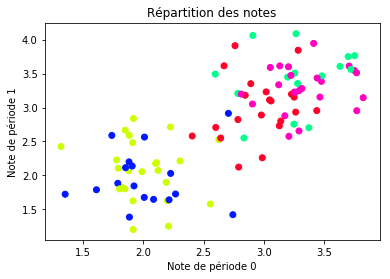

In [7]:
plt.scatter(X,Y,c=cluster_attribution,cmap='gist_rainbow')
plt.title('Répartition des notes')
plt.xlabel('Note de période 0')
plt.ylabel('Note de période 1')
plt.show()

Dans la figure ci-dessus, chaque couleur correspond à un cluster.

In [8]:
N = pop
D0 = np.zeros((N,N))
D1 = np.zeros((N,N))
for i in range(N):
    for j in range(i,N):
        if cluster_attribution[i]==cluster_attribution[j]:
            proba = 0.15
        else: 
            proba = prox[cluster_attribution[i],cluster_attribution[j]]
        f0 = binomial(1,proba)
        f1 = binomial(1,proba)
        D0[i,j] = f0
        D0[j,i] = f0
        D1[i,j] = f1
        D1[j,i] = f1

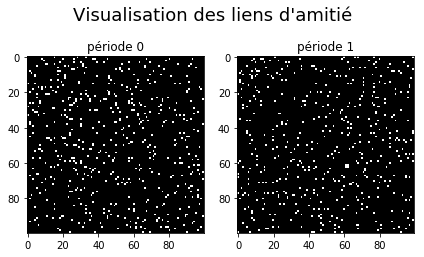

In [9]:
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(D0,cmap='gray')
ax1.set_title('période 0')
ax2.imshow(D1,cmap='gray')
ax2.set_title('période 1')
fig.suptitle("Visualisation des liens d'amitié",fontsize=18)
plt.tight_layout()
plt.show()

In [10]:
M0 = np.sum(D0,axis=1)
G0 = np.linalg.solve(np.diag(M0),D0)
M1 = np.sum(D1,axis=1)
G1 = np.linalg.solve(np.diag(M1),D1)
F0 = (np.dot(D0,D0)>0).astype(np.int)
F1 = (np.dot(D1,D1)>0).astype(np.int)

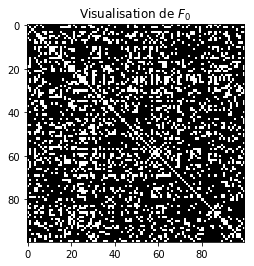

In [11]:
plt.imshow(F0,cmap='gray')
plt.title('Visualisation de $F_0$')
plt.show()

### 1.2 Statistiques descriptives

In [12]:
df = pd.DataFrame([],index=['Y','X',"nombre d'amis 1","nombre d'amis 2"],columns = ['mean','std','min','max'])
df.loc['Y'] = [np.mean(Y),np.std(Y),np.min(Y),np.max(Y)]
df.loc['X'] = [np.mean(X),np.std(X),np.min(X),np.max(X)]
nbamis1 = np.sum(D0,axis=1)
nbamis2 = np.sum(D1,axis=1)
df.loc["nombre d'amis 1"] = [np.mean(nbamis1),np.std(nbamis1),np.min(nbamis1),np.max(nbamis1)]
df.loc["nombre d'amis 2"] = [np.mean(nbamis2),np.std(nbamis2),np.min(nbamis2),np.max(nbamis2)]
df

,mean,std,min,max
Y,2.73225,0.72761,1.20183,4.08889
X,2.70582,0.662025,1.31755,3.82355
nombre d'amis 1,5.41,2.15914,1,11
nombre d'amis 2,4.79,1.94059,1,9


## 2. Modèle LIM

On fait la régression bayésienne, avec les a posteriori conjugués (inverse-$\chi^2(1)$, normale conditionnelle).

si on veut juste les means et vars, il suffit de les calculer les paramètres des posterior.

In [13]:
#a priori
#on a 4 coefficients beta sur lesquels travailler 
mu0 = np.zeros(4) #moyenne de la gaussienne conditionnelle
Q0 = np.diag(np.ones(4)) #variance de la gaussienne conditionnelle
a0 = 1 #coefficient de l'inverse gamma
b0 = 1 #coefficient d'échelle de l'inverse gamma

In [14]:
#construction des variables explicatives et variables cibles
Ybar = G1.dot(Y)
Xbar = G1.dot(X)
features = np.column_stack((np.ones(len(Y)),Ybar,X,Xbar))

Les paramètres du modèle sont mis à jour selon les équations suivantes :
$$ Q_{n}=(\mathbf {X} ^{\rm {T}}\mathbf {X} + Q_{0}) $$
$$  \boldsymbol\mu_n=(\mathbf{X}^{\rm T}\mathbf{X}+ Q_0)^{-1} (Q_0\boldsymbol\mu_0+\mathbf{X}^{\rm T}\mathbf{y})  $$ 
$$ a_{n}=a_{0}+{\frac  {n}{2}} $$ 
$$ b_{n}=b_{0}+{\frac  {1}{2}}({\mathbf  {y}}^{{{\rm {T}}}}{\mathbf  {y}}+{\boldsymbol  \mu }_{0}^{{{\rm {T}}}}Q_{0}{\boldsymbol  \mu }_{0}-{\boldsymbol  \mu }_{n}^{{{\rm {T}}}}Q_{n}{\boldsymbol  \mu }_{n}) $$

In [15]:
#mise à jour des paramètres: calcul des distributions a posteriori
Qn = features.T.dot(features) + Q0
mun = np.linalg.solve(Qn,Q0.dot(mu0)+features.T.dot(Y))
invQn = np.linalg.solve(Qn,np.identity(4))
an = a0+len(Y)/2
bn = b0 + 0.5*(Y.dot(Y)+mu0.T.dot(Q0.dot(mu0))-mun.T.dot(Qn.dot(mun)))

In [16]:
#moyennes des lois normales a posteriori
df = pd.DataFrame([],index=['beta0','beta_ybar','beta_x','beta_xbar'],columns = ['mean','std'])
stds = [np.sqrt(invQn[i,i]) for i in range(len(Qn))]
df['mean'] = mun
df['std'] = stds
df

,mean,std
beta0,-0.011526,0.514213
beta_ybar,0.412338,0.368857
beta_x,0.658052,0.187996
beta_xbar,-0.056783,0.414881


In [17]:
#matrice de variance covariance
Qn

array([[101.        , 270.21419871, 270.5818472 , 265.71037299],
       [270.21419871, 756.57760759, 750.957247  , 737.7123471 ],
       [270.5818472 , 750.957247  , 776.97310229, 736.98179159],
       [265.71037299, 737.7123471 , 736.98179159, 726.65791264]])

In [18]:
print(f"Moyenne de sigma2: {bn/(an-1):.2f}")
print(f"Variance de sigma2: {bn**2/((an-1)**2*(an-2)):.2f}")

Moyenne de sigma2: 0.22
Variance de sigma2: 0.00


Pour les commentaires sur les valeurs, voir le rapport joint.

## 3. Modèle exogène

$\alpha \sim \mathcal{N}(0,1)$ (chaque $\alpha$ suit une loi normale de façon indépendante)

$\displaystyle{P(D_{1,ij} = 1|D_{0},X)  = (\frac{e^{\alpha_{0} + \alpha_{x}|Xi-Xj| + \alpha_{d}D_{0ij}+ \alpha_{f}F_{0ij}}}{1 + e^{\alpha_{0} + \alpha_{x}|Xi-Xj| + \alpha_{d}D_{0ij}+ \alpha_{f}F_{0ij}}})^2}$



### 3.1 Méthode

In [19]:
#a priori 
alpha0 = np.random.randn(1)
alphax = np.random.randn(1)
alphad = np.random.randn(1)
alphaf = np.random.randn(1)
alpha = np.random.randn(4)

In [20]:
#feature engineering 
#we must create |Xi-Xj| for each (i,j) couple 
dist = np.zeros((N,N))
for i in range(N):
    for j in range(i,N):
        value = np.abs(X[i]-X[j])
        dist[i][j] = value
        dist[j][i] = value

In [21]:
#matrix of utilities
U = np.exp(alpha[0]*np.ones((N,N))+alpha[1]*dist+alpha[2]*D0+alpha[3]*F0)

In [22]:
#We create a new D1 matrix based on the probability formula
D1_new = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        p = (U[i,j])/(1 + U[i,j])
        D1_new[i,j] = np.random.binomial(1,p**2)

In [23]:
def posterior(a,x,theta):
    """
    parameters
    ----------
    a: array of alpha parameters
    x: D1 
    theta: array [np.ones,(|Xi-Xj|),D0,F0]
    """
    N = x.shape[0]
    res = np.exp(-0.5*a.dot(a))**(N*(N-1)*0.5)
    for i in range(N):
        for j in range(i+1,N):
            #compute <alpha,theta>
            ps = 0
            for k in range(4):
                ps += a[k]*theta[k][i,j] 
            res *= np.exp(2*x[i,j]*ps)
    return res

In [24]:
#Metropolis Hastings with normal kernel 
theta = [np.ones((N,N)),dist,D0,F0]
alpha_list = [alpha]
n_iter = 1000
for i in range(n_iter): 
    y = alpha + np.random.randn(4)
    ratio = posterior(y,D1,theta)/posterior(alpha,D1,theta)*1 #1 is the kernel ratio term 
    p_accept = min([1,ratio])
    b = binomial(1,p_accept)
    alpha = b*y+(1-b)*alpha
    alpha_list.append(alpha)

C:\Users\benoit\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


### 3.2 Résultats

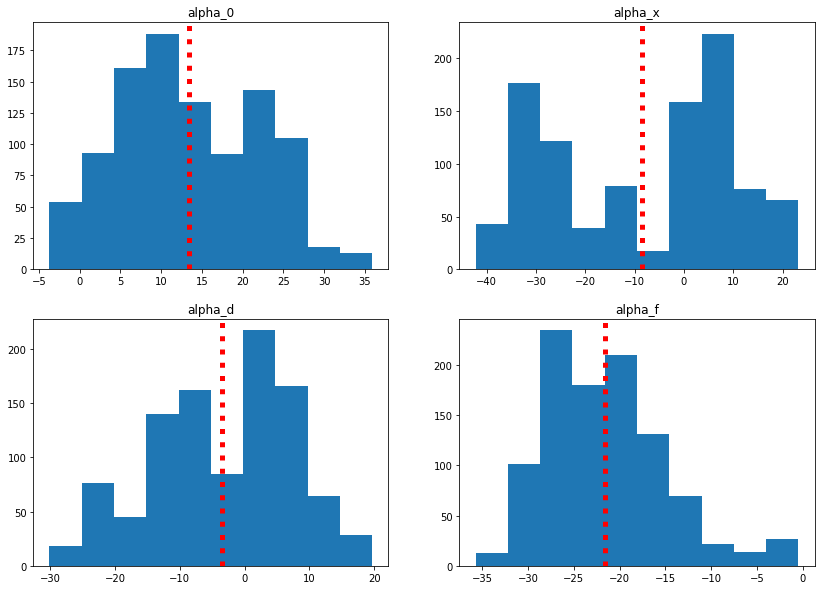

In [25]:
fig = plt.figure(figsize=(14,10))
titles = ['alpha_0','alpha_x','alpha_d','alpha_f']
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    alpha0 = [a[i] for a in alpha_list]
    ax.hist(alpha0)
    ax.set_title(titles[i])
    ax.axvline(np.mean(alpha0),ls='dotted',c='r',linewidth = 5)
plt.show()

In [26]:
df = pd.DataFrame([],index=['a0','ax','ad','af'],columns = ['mean','std'])
for i in range(4):
    alpha0 = [a[i] for a in alpha_list]
    df.iloc[i,:] = [np.mean(alpha0),np.std(alpha0)]
df

,mean,std
a0,13.3801,8.52597
ax,-8.57066,18.4558
ad,-3.39877,10.6673
af,-21.5606,6.54788


On stocke les valeurs de $\alpha$ pour la suite.

In [27]:
alphas = df['mean'].values

## 4. Modèle endogène

In [28]:
betas = mun #results from 1st part
beta_cov_mat = Qn #from the first part
beta_xi = 0.1*np.random.randn(1) #normal with variance 0.01
alpha_xi = -1 + 0.1*np.random.randn(1) #N(-1,0.01)
xi = binomial(1,0.5,size=N)
xi[0] = 1
sigma2 = 2 #à corriger avec les résultats d'avant 

### 4.1 Mise à jour des $\xi_i$

In [29]:
#update of the xi_i
theta = [np.ones((N,N)),dist,D0,F0]
n_iter = 10
for n in range(n_iter):
    probas = []
    for i in range(N):
        #compute binomial parameter
        p0 = 0
        p1 = 0
        for j in range(N):
            for k in range(4):
                p0 += 2*D1[i,j]*alphas[k]*theta[k][i,j]
            p1 += p0
        p0 += 2*alpha_xi*np.sum(D1[i,:].dot(xi))
        p1 += 2*alpha_xi*(N-np.sum(D1[i,:].dot(xi)))
        proba = 1/(1+np.exp(p1-p0))
        probas.append(proba)
        xi[i] = binomial(1,proba)

C:\Users\benoit\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


In [30]:
xi

array([1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0])

### 4.2 Mise à jour des $\beta$

In [31]:
def posterior_endo(b,bxi,sigma2,xi,a,axi,D):
    """
    compute log posterior then go exp 
    b is the beta vector [beta_0,beta_x,beta_ybar,beta_xbar]
    """
    N = D.shape[0]
    res = -0.5*np.linalg.norm(b[:-1]) #prior of beta
    res += -0.5*b[-1]**2/(0.01**2) #prior of beta xi
    res += np.sum([probas[i]*xi[i]+(1-probas[i])*(1-xi[i])]) #prior of xi
    res += chi2.ppf(sigma2,df=10) #prior of sigma2
    res += -0.5*np.linalg.norm(a) #prior of alpha
    res += -0.5*(axi+1)**2/(0.01**2) #prior of alpha_xi
    #compute pi(Y|b) 
    I = np.identity(N)
    A = np.linalg.inv(I-b[2]*G1)
    mean =  b[0]*np.ones(N)+b[1]*X+b[3]*G1.dot(X)+bxi*xi
    mean = A.dot(mean)
    var = sigma2*A.dot(A.T)
    inv_var = I-b[2]*G1
    res += -N/2*np.log(np.linalg.det(var))
    res += -0.5*(Y-mean).T.dot(inv_var).dot(Y-mean)
    
    return res

In [32]:
#update betas 
n_iter = 100
beta_list = [betas]
beta_xi_list = [0]
for i in range(n_iter):
    y = betas + (1/16)*Qn.dot(np.random.randn(4)) #normal centered on previous values with previous cov matrix
    yxi = 0.1*np.random.randn(1)[0]
    #computation of the beta posterior
    pi_prev = posterior_endo(beta_list[-1],beta_xi_list[-1],sigma2,xi,alphas,alpha_xi,D1)
    pi_suiv = posterior_endo(y,beta_xi_list[-1],sigma2,xi,alphas,alpha_xi,D1)
    #computation of ratio 
    ratio = pi_suiv/pi_prev
    inv_Qn = np.linalg.inv(Qn)
    ratio *= np.exp(-0.5*((beta_list[-1]-y).T.dot(inv_Qn).dot(beta_list[-1]-y)+100*(beta_xi_list[-1]-yxi)**2))
    #comparison with 1
    p_accept = min([1,ratio])
    #decision
    if binomial(1,p_accept):
        beta_list.append(y)
        beta_xi_list.append(yxi)
    else: 
        beta_list.append(beta_list[-1])
        beta_xi_list.append(beta_xi_list[-1])
            

C:\Users\benoit\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
C:\Users\benoit\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


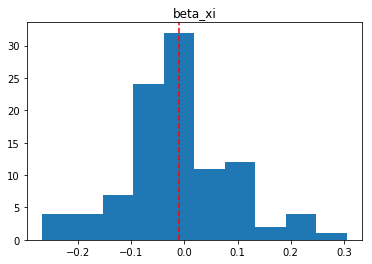

In [33]:
plt.hist(beta_xi_list)
plt.axvline(np.mean(beta_xi_list),ls='--',c='r')
plt.title('beta_xi')
plt.show()

In [34]:
df_beta = pd.DataFrame([],index=['beta0','betax','beta_ybar','beta_xbar','beta_xi'],columns = ['mean','std'])
for i in range(4):
    x1 = np.mean([b[i] for b in beta_list])
    x2 = np.std([b[i] for b in beta_list])
    df_beta.iloc[i] = [x1,x2]
df_beta.iloc[4] = [np.mean(beta_xi_list),np.std(beta_xi_list)]
df_beta

,mean,std
beta0,-0.64449,24.3214
betax,-1.33933,67.4896
beta_ybar,-1.18015,68.1361
beta_xbar,-1.7376,66.2062
beta_xi,-0.0100478,0.101988


In [35]:
betas = df_beta['mean'].values

### 4.3 Mise à jour de $\sigma^2$

On effectue cette mise à jour par Gibbs sampling.

In [36]:
sigma2_list = []
for k in range(100):
    invchi2 = chi2.ppf(np.random.rand(),df=10)
    I = np.identity(N)
    A = np.linalg.inv(I-betas[2]*G1)
    mu_y = betas[0]*np.ones(N)+betas[1]*X+betas[3]*G1.dot(X)+betas[4]*xi
    mu_y = A.dot(mu_y)
    var = np.matmul(I-betas[2]*G1,I-betas[2]*G1)
    tau2 =  (1/11)*(Y-mu_y).dot(var.dot(Y-mu_y))
    sigma2 = invchi2/(11*tau2)
    sigma2_list.append(sigma2)

In [37]:
sigma2 = np.mean(sigma2_list)
sigma2

0.00038290697616250973

### 4.4 Mise à jour des $\alpha$

On utilise le même algorithme de Metropolis-Hastings que précédemment avec quelques changements mineurs pour prendre en compte les variables $\xi$.

In [38]:
alphas = np.append(alphas,alpha_xi)

In [39]:
def alpha_posterior_endo(a,x,theta):
    """
    parameters
    ----------
    a: array of alpha parameters
    x: D1 
    theta: array [np.ones,(|Xi-Xj|),D0,F0,xi]
    """
    N = x.shape[0]
    res = np.exp(-0.5*a.dot(a))**(N*(N-1)*0.5)
    for i in range(N):
        for j in range(i+1,N):
            #compute <alpha,theta>
            ps = 0
            for k in range(5):
                ps += a[k]*theta[k][i,j] 
            res *= np.exp(2*x[i,j]*ps)
    return res

In [40]:
#Metropolis Hastings with normal kernel 
theta = [np.ones((N,N)),dist,D0,F0,xi]
alpha_list = [alphas]
n_iter = 1000
for i in range(n_iter): 
    y = alphas + np.random.randn(5)
    ratio = posterior(y,D1,theta)/posterior(alphas,D1,theta)*1 #1 is the kernel ratio term 
    p_accept = min([1,ratio])
    b = binomial(1,p_accept)
    alphas = b*y+(1-b)*alphas
    alpha_list.append(alphas)

C:\Users\benoit\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


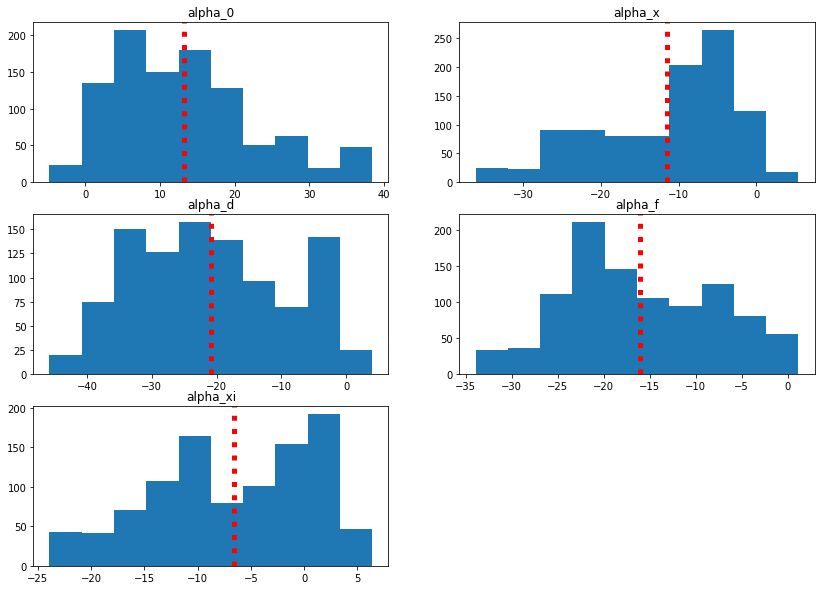

In [41]:
fig = plt.figure(figsize=(14,10))
titles = ['alpha_0','alpha_x','alpha_d','alpha_f','alpha_xi']
for i in range(5):
    ax = fig.add_subplot(3,2,i+1)
    alpha0 = [a[i] for a in alpha_list]
    ax.hist(alpha0)
    ax.set_title(titles[i])
    ax.axvline(np.mean(alpha0),ls='dotted',c='r',linewidth = 5)
plt.show()

In [42]:
df = pd.DataFrame([],index=['a0','ax','ad','af','a_xi'],columns = ['mean','std'])
for i in range(5):
    alpha0 = [a[i] for a in alpha_list]
    df.iloc[i,:] = [np.mean(alpha0),np.std(alpha0)]
df

,mean,std
a0,13.1654,9.41042
ax,-11.5313,8.97993
ad,-20.9057,11.7339
af,-16.0531,8.18359
a_xi,-6.6154,7.42073


In [43]:
alphas = df['mean'].values

### 4.5 Deuxième mise à jour des $\xi$

In [44]:
n_iter = 100
for n in range(n_iter):
    probas = []
    for i in range(N):
        #compute binomial parameter
        p0 = 0
        p1 = 0
        for j in range(N):
            for k in range(4):
                p0 += 2*D1[i,j]*alphas[k]*theta[k][i,j]
            p1 += p0
        p0 += 2*alphas[4]*np.sum(D1[i,:].dot(xi))
        p1 += 2*alphas[4]*(N-np.sum(D1[i,:].dot(xi)))
        proba = 1/(1+np.exp(p1-p0))
        probas.append(proba)
        xi[i] = binomial(1,proba)

C:\Users\benoit\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  


In [45]:
xi

array([1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0])

Nos valeurs n'ont pas forcément de sens: tout a été sélectionné au hasard

## 5. Hétérogénéité des *peer effects*

On utilise une matrice de réseau à l'étape 1 qui n'est plus symétrique (i ami de j n'implique pas j ami de i)  

In [46]:
D1 = np.random.randint(2,size=(N,N))
D0 = np.random.randint(2,size=(N,N))

On fait la même chose qu'en 1. avec différentes matrices de réseau et des modèles étendus.

In [47]:
def heterogeneity(name):
    """
    réalise les estimations de la partie MLIM avec d'autres réseaux 
    parameters
    ----------
    name : définition du réseau utilisée
    
    returns
    -------
    df : pd.DataFrame contenant les means et vars pour beta et sigma2
    """
    
    if name=='lagged':
        DB = D0 * (1 - D1)
    elif name =='mutual':
        DB = np.asarray([[D1[i,j]==D1[j,i] for j in range(N)] for i in range(N)])
    elif name=='fof': #friends of friends
        DM = np.asarray([[D1[i,j]==D1[j,i] for j in range(N)] for i in range(N)])
        FM = (np.dot(DM,DM)>0).astype(np.int)
        DB = (1 - D1) * FM
    else: 
        raise ValueError(name + ' is not a correct network specification')
    #priors 
    #on a 6 coefficients beta sur lesquels travailler 
    mu0 = np.zeros(6) #mean of the conditional normal distribution 
    Q0 = np.diag(np.ones(6)) #var of the conditional normal distribution
    a0 = 1 #coef of the inverse gamma
    b0 = 1 #scaling coefficient of the inverse gamma

    #construction du réseau B
    MB = np.sum(DB,axis=1)
    GB = np.linalg.solve(np.diag(MB),DB)
    #construction des variables explicatives et variables cibles
    YbarA = G1.dot(Y)
    XbarA = G1.dot(X)
    YbarB = GB.dot(Y)
    XbarB = GB.dot(X)
    features = np.column_stack((np.ones(len(Y)),X,YbarA,XbarA,YbarB,XbarB))

    #updating parameters: computing the posterior distribution parameters
    Qn = features.T.dot(features) + Q0
    mun = np.linalg.solve(Qn,Q0.dot(mu0)+features.T.dot(Y))
    an = a0+len(Y)/2
    bn = b0 + 0.5*(Y.dot(Y)+mu0.T.dot(Q0.dot(mu0))-mun.T.dot(Qn.dot(mun)))
    
    
    df = pd.DataFrame([],index=['beta0','betax','beta_ybarA','beta_xbarA','beta_ybarB','beta_xbarB','sigma2'],columns = ['mean','std'])
    for i in range(6):
        x1 = mun[i]
        x2 = np.sqrt(Qn[i,i])
        df.iloc[i] = [x1,x2]
    
    df.iloc[6] = [bn/(an-1),np.sqrt(bn**2/((an-1)**2*(an-2)))]
    print(df)
    
    return df  

In [48]:
df_lagged = heterogeneity('lagged')

                  mean        std
beta0      -0.00774143    10.0499
betax         0.659295    27.8742
beta_ybarA    0.402994     27.506
beta_xbarA  -0.0527118    26.9566
beta_ybarB   -0.165189    27.3461
beta_xbarB    0.168826    27.1817
sigma2         0.22361  0.0319443


In [49]:
df_mutual = heterogeneity('mutual')

                 mean        std
beta0       0.0207921    10.0499
betax        0.658532    27.8742
beta_ybarA   0.412471     27.506
beta_xbarA -0.0533182    26.9566
beta_ybarB  0.0109095    27.2681
beta_xbarB -0.0271871    26.9606
sigma2        0.22427  0.0320386


In [50]:
df_fof = heterogeneity('fof')

                 mean        std
beta0      -0.0936651    10.0499
betax        0.657007    27.8742
beta_ybarA   0.409374     27.506
beta_xbarA -0.0632228    26.9566
beta_ybarB -0.0438288    27.2271
beta_xbarB  0.0850132    27.0962
sigma2       0.224097  0.0320139


## 6. Modèle auto-régressif

In [51]:
#priors 
#on a 4 coefficients gamma sur lesquels travailler 
mu0 = np.zeros(4) #mean of the conditional normal distribution 
Q0 = np.diag(np.ones(4)) #var of the conditional normal distribution

#construction des variables explicatives et variables cibles
GX = G1.dot(X)
GGX = G1.dot(GX)
features = np.column_stack((np.ones(len(Y)),X,GX,GGX))

#updating parameters: computing the posterior distribution parameters
Qn = features.T.dot(features) + Q0
mun = np.linalg.solve(Qn,Q0.dot(mu0)+features.T.dot(Y))

In [52]:
df = pd.DataFrame([],index=['gamma0','gammaX','gamma1','gamma2'],columns = ['mean','std'])
for i in range(4):
    x1 = mun[i]
    x2 = np.sqrt(Qn[i,i])
    df.iloc[i] = [x1,x2]
df

,mean,std
gamma0,-0.0816905,10.0499
gammaX,0.657279,27.8742
gamma1,0.255257,26.9566
gamma2,0.13394,26.9356


In [53]:
bx = df['mean']['gammaX']
bybar = df['mean']['gamma2']/df['mean']['gamma1']
bxbar = df['mean']['gamma1'] - bx * bybar
b0 = (I - bybar*G1).dot(df['mean']['gamma0']*np.ones(N))[0]

In [54]:
df = pd.DataFrame([],index=['beta0','betaX','beta_xbar','beta_FIC'],columns = ['mean'])
df['mean']['beta0'] = b0
df['mean']['betaX'] = bx
df['mean']['beta_xbar'] = bxbar
df['mean']['beta_FIC'] = bybar

df

,mean
beta0,-0.0388255
betaX,0.657279
beta_xbar,-0.0896335
beta_FIC,0.524725


Le $\hat{\beta}_{FIC}$ est négatif puisqu'on n'a pas modélisé la dépendance interclusters en fonction de la variable Y (et donc on ne retrouve aucun impact rationnel)